# 1. Create Synthetic Network

In [61]:
import numpy as np
from synthetic_network import grow_network

np.random.seed(1000)

# Dimensions of virtual plate
xmin = -260
xmax = 260
ymin = 0
ymax = 260


# Network occupancy grids
g_res = 1  # grid resolution per unit distance
g_rows = (ymax - ymin) * g_res  # number of grid rows
g_cols = (xmax - xmin) * g_res  # number of grid columns
fungus_grid = np.zeros([g_rows, g_cols], dtype=np.int32)  # fungus occupancy grid
obstacle_grid = np.zeros([g_rows, g_cols], dtype=np.int32)  # obstacle occupancy grid
grids = {"fungus": fungus_grid, "obstacle": obstacle_grid}

(network, tip_nodes) = grow_network(101, grids)

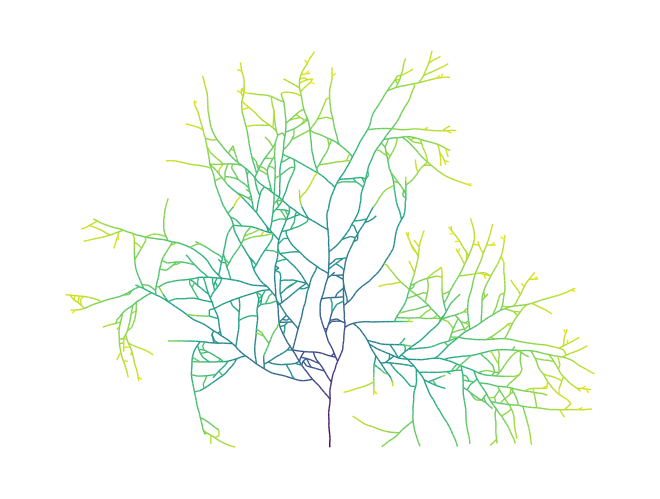

In [71]:
import networkx as nx

g = nx.from_numpy_array(network['conn'])
pos = {n: pos for n, pos in enumerate(network['coords'])}
nx.set_node_attributes(g, pos, 'position')
for u, v in g.edges():
    if u < v:
        g[u][v]['pixels'] = [pos[u], pos[v]]
    else:
        g[u][v]['pixels'] = [pos[v], pos[u]]
edges = g.edges()
colors = [g[u][v]['weight'] for u,v in edges]
degree_3_nodes = []
for n in g:
    if g.degree[n]>=3:
        degree_3_nodes.append(n)
nx.draw(g, pos, edgelist=edges, edge_color=colors, nodelist=[], node_size=10)

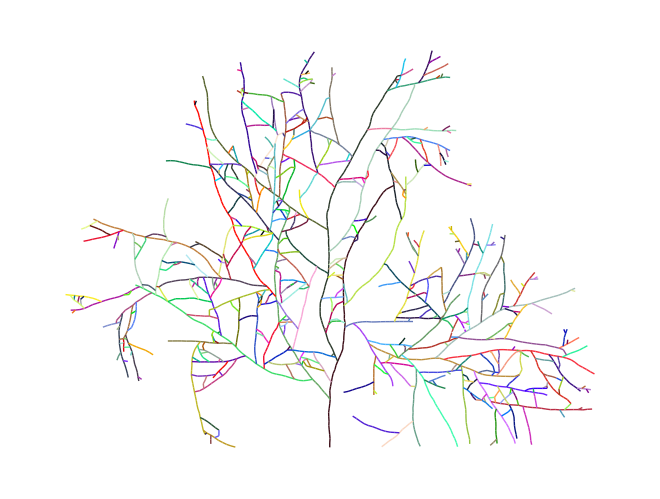

In [63]:
import networkx as nx

g2 = nx.from_numpy_array(network['conn_hyperedge'])
edges = g2.edges()
hyperedges = [g2[u][v]['weight'] for u,v in edges]
def random_color():
    return [np.random.randint(0,256) for _ in range(3)]
colors_dict = {h: random_color() for h in hyperedges}
colors = [colors_dict[hyperedge] for hyperedge in hyperedges]
nx.draw(g2, {n: pos for n, pos in enumerate(network['coords'])}, edgelist=edges, edge_color=colors, node_size=0)

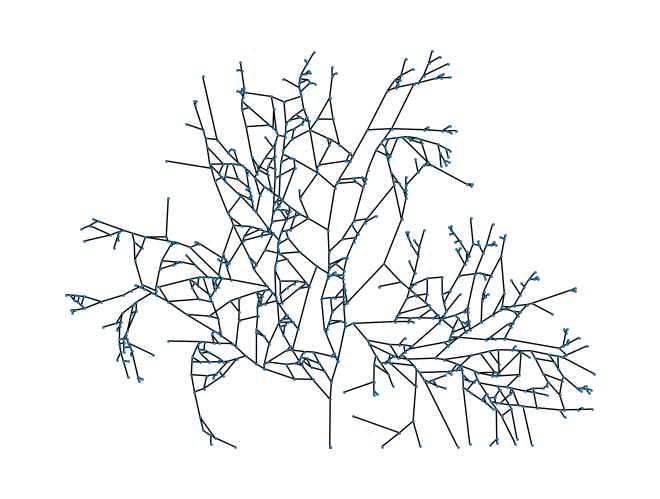

In [64]:
G = g.copy()
nodes_to_remove = [n for n in G.nodes if len(list(G.neighbors(n))) == 2]

# For each of those nodes
for node in nodes_to_remove:
    # We add an edge between neighbors (len == 2 so it is correct)
    G.add_edge(*G.neighbors(node))
    # And delete the node
    G.remove_node(node)

nx.draw(G, {n: pos for n, pos in enumerate(network['coords'])}, node_size=1)

# 2. Timesteps

In [113]:
g = nx.from_numpy_array(network['conn'], create_using=nx.DiGraph)
pos = {n: pos for n, pos in enumerate(network['coords'])}
nx.set_node_attributes(g, pos, 'position')
for u, v in g.edges():
    g[u][v]['pixels'] = [pos[u], pos[v]]
    g[u][v]['hyperedge'] = g2[u][v]['weight']


graphs = []
for i in range(1, 102, 4):
    subedges = [edge for edge in g.edges() if g[edge[0]][edge[1]]['weight'] <= i]
    subg = g.edge_subgraph(subedges).copy()
    nodes_to_remove = [n for n in subg.nodes if subg.in_degree(n) == 1 and subg.out_degree(n) == 1]
    # For each of those nodes
    for node in nodes_to_remove:
        # We add an edge between neighbors (len == 2 so it is correct)
        in1, in2 = list(subg.in_edges(node))[0]
        out1, out2 = list(subg.out_edges(node))[0]
        subg.add_edge(in1, out2, pixels=subg[in1][in2]['pixels'] + subg[out1][out2]['pixels'][1:], hyperedge=subg[in1][in2]['hyperedge'])
        # And delete the node
        subg.remove_node(node)
    graphs.append(nx.Graph(subg))

# 3. Test Corresponding stg

## Set Up Stg

In [104]:
from sthype import SpatialGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs
from sthype.plot import plot_spatial_temporal_graph, plot_spatial_temporal_graph_node, plot_spatial_graph, plot_spatial_temporal_graph_hyperedge
import matplotlib.pyplot as plt
import os
import pickle

%load_ext autoreload
%autoreload 2

In [105]:
spatial_graphs = [SpatialGraph(graph) for graph in graphs]
spatial_graph = spatial_graphs[-1]
sg = spatial_graph

In [110]:
spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), threshold=0.1, segments_length=0.1, verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 25
Comparing with graph 24
Comparing with graph 23
Comparing with graph 22
Comparing with graph 21
Comparing with graph 20
Comparing with graph 19
Comparing with graph 18
Comparing with graph 17
Comparing with graph 16
Comparing with graph 15
Comparing with graph 14
Comparing with graph 13
Comparing with graph 12
Comparing with graph 11
Comparing with graph 10
Comparing with graph 9
Comparing with graph 8
Comparing with graph 7
Comparing with graph 6
Comparing with graph 5
Comparing with graph 4
Comparing with graph 3
Comparing with graph 2
Comparing with graph 1
Comparing with graph 0


## Plot Stg

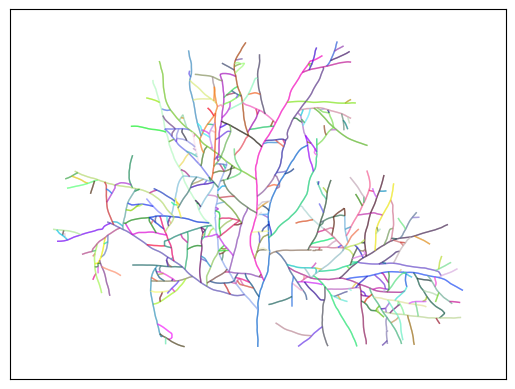

In [111]:
plot_spatial_temporal_graph(stg, color_group='hyperedge')

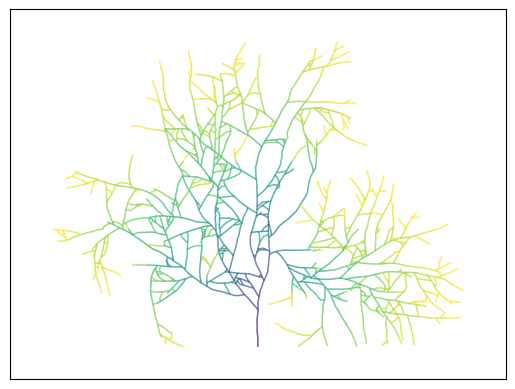

In [112]:
plot_spatial_temporal_graph(stg, color_group='activation')

## Evaluate hyperedge accuracy

In [115]:
import collections

initial_graph = stg.get_initial_graph()
last_graph = lg = graphs[-1]

bad_match = 0
total = 0
for n in lg:
    neighbors = list(lg.neighbors(n))
    hyperedges = [lg[n][node]['hyperedge'] for node in neighbors]
    duplicates = [item for item, count in collections.Counter(hyperedges).items() if count > 1]
    for duplicate in duplicates:
        total += 1
        indices = [i for i, x in enumerate(hyperedges) if x == duplicate]
        h = initial_graph[n][neighbors[indices[0]]]['hyperedge']
        for i in indices:
            if initial_graph[n][neighbors[i]]['hyperedge'] != h:
                bad_match+=1
                continue

print('Good match over total :', total-bad_match, '/', total)

Good match over total : 609 / 638
